# Загрузка Pandas и очистка данных

In [7]:
import pandas as pd
import numpy as np
import re

from sklearn import preprocessing

df = pd.read_csv('main_task.csv')
X = df.drop(['Reviews', 'URL_TA', 'ID_TA', 'Rating', 'City', 'Restaurant_id', 'Cuisine Style', 'Price Range'], axis=1)
X['PriceRange_isNAN'] = pd.isna(df['Price Range']).astype('uint8')
df['Price Range'].fillna('$$ - $$$', inplace=True)

In [8]:
X.sample()

,Ranking,Number of Reviews,PriceRange_isNAN
38834,133.0,242.0,0


In [10]:
# Dummy based on price range
le = preprocessing.LabelEncoder()
X['Price Range'] = le.fit_transform(df['Price Range'])

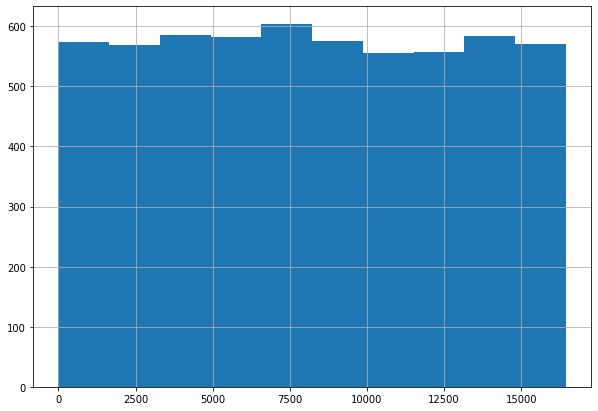

In [24]:
df['Ranking'][df['City'] =='London'].hist(bins=10)

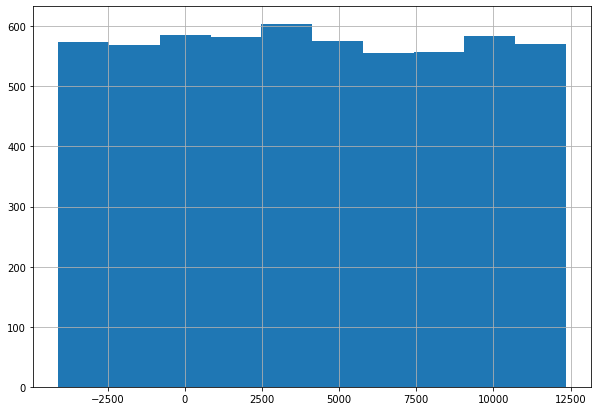

In [31]:
(df['Ranking'][df['City'] =='London'] - rank_London/2).hist(bins=10)

In [29]:
rank_London = df['Ranking'][df['City'] =='London'].mean()

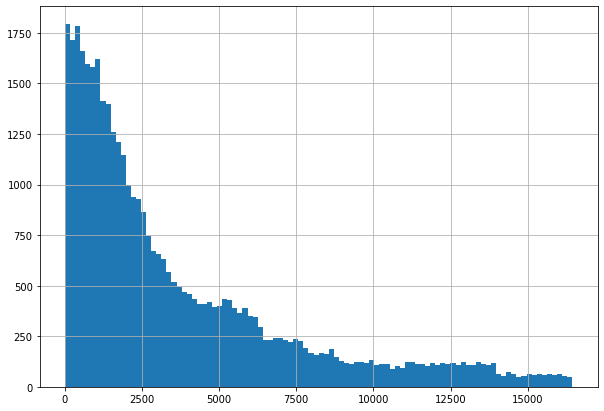

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline


plt.rcParams['figure.figsize'] = (10,7)
df['Ranking'].hist(bins=100)



In [49]:
# Dummy based on cities

country = {'Paris': 'France', 'Stockholm': 'Sweden', 'London': 'GB', 'Berlin': 'Germany', 'Munich': 'Germany',
           'Oporto': 'Portugal', 'Milan': 'Italy', 'Bratislava': 'Slovak', 'Vienna': 'Austria', 'Rome': 'Italy',
           'Barcelona': 'Spain', 'Madrid': 'Spain', 'Dublin': 'Ireland', 'Brussels': 'Belgium', 'Zurich': 'Switzerland',
           'Warsaw': 'Poland', 'Budapest': 'Hungary', 'Copenhagen': 'Sweden', 'Amsterdam': 'Dutch', 'Lyon': 'France',
           'Hamburg': 'Germany', 'Lisbon': 'Portugal', 'Prague': 'Czech','Oslo': 'Denmark', 'Helsinki': 'Finland',
           'Edinburgh': 'GB', 'Geneva': 'Switzerland', 'Ljubljana': 'Slovak', 'Athens': 'Greece', 
           'Luxembourg': 'Luxembourg', 'Krakow': 'Poland'}

t2 = pd.get_dummies(df['City'])
X = X.join(t2)

In [50]:
# Dummy based on Cuisine Style

import re

df['Cuisine Style'].fillna("", inplace=True)
df['Cuisine Style_'] = df['Cuisine Style'].apply(lambda x: re.findall('\w+\s*\w+\s*\w+', str(x)))
cuisine_dict = {}
cuisine_freq = {}
cuisine_venue = {}
idx = 0
indx = 0

def create_dict(x):
    global idx, indx
    if len(x['Cuisine Style_']) == 0:
        cuisine_venue[indx] = 1
    else:
        cuisine_venue[indx] = len(x['Cuisine Style_'])
    indx += 1
    for each in x['Cuisine Style_']:     
        if not each in cuisine_dict:
            cuisine_dict[each] = idx
            cuisine_freq[each] = 1
            idx += 1
        else:
            cuisine_freq[each] += 1 
df.apply(create_dict, axis=1)

bar_venue = ['Bar', 'Pub', 'Wine Pub', 'Brew Pub']
fast_venue = ['Pizza', 'Fast Food', 'Street Food']
cafe_venue = ['Cafe', 'Gastropub', 'Diner']
vegan_venue = ['Vegetarian Friendly', 'Vegan Options', 'Gluten Free Options']
meat_venue = ['Grill', 'Steakhouse', 'Barbecue']
seafood_venue = ['Seafood', 'Sushi']

def dummy_venue(row):
    temp = [0,0,0,0,0,0,0]
    if  len(row['Cuisine Style_']) == 0:
        temp[0] = 1
    else:
        for each in row['Cuisine Style_']:
            if each in bar_venue:
                   temp[1] = 1
            if each in fast_venue:
                    temp[2] = 1
            if each in cafe_venue:
                    temp[3] = 1
            if each in vegan_venue:
                    temp[4] = 1
            if each in meat_venue:
                    temp[5] = 1
            temp[6] = 1
    return pd.Series(temp)

t3 = df.apply(dummy_venue, axis=1)
t3.columns = ['boom', 'bar', 'cafe', 'fastfood', 'vegan', 'meat', 'national']
X = X.join(t3)

In [51]:
# Dummy based on positive reviews

X['is_good'] = df['Reviews'].apply(lambda x: 0 if pd.isna(re.search("Good|good|excellent|Excellent|awesome|Awesome|Best|best|Nice|nice", x)) else 1)

In [52]:
#Dummy based on delta timestamp

def review_time(row):
    match = re.findall('\d\d/\d\d/\d\d\d\d', row['Reviews'])
    if len(match) == 0:
        return [pd.to_datetime('10/25/2017', format='%m/%d/%Y'), pd.to_datetime('10/25/2017', format='%m/%d/%Y')]
    elif len(match) == 1:
        return [pd.to_datetime(match[0], format='%m/%d/%Y'), pd.to_datetime('10/25/2017', format='%m/%d/%Y')]
    return [pd.to_datetime(match[0], format='%m/%d/%Y'), pd.to_datetime(match[1], format='%m/%d/%Y')]
df2 = df.apply(review_time, axis=1, result_type='expand')
fake = pd.to_datetime('10/25/2017',  format='%m/%d/%Y')
t5 = df2.apply(lambda x: (x[0]-x[1]).days if not x[0] == fake or not x[1] == fake else 100000, axis=1)
t5 = t5.apply(lambda x: 0 if x > 64 else 1)
t5 = pd.DataFrame(t5, columns=['delta'])
X = X.join(t5)

In [53]:
X.head()

,Ranking,Number of Reviews,low,mean,high,Amsterdam,Athens,Barcelona,Berlin,Bratislava,...,Zurich,boom,bar,cafe,fastfood,vegan,meat,national,is_good,delta
0,5570.0,194.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
1,1537.0,10.0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,353.0,688.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,1,1,0,1
3,3458.0,3.0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
4,621.0,84.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,1,0


# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [54]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
y = df['Rating']

# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Создаём, обучаем и тестируем модель

In [55]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

# Создаём модель
regr = RandomForestRegressor(n_estimators=100, random_state=42)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.21284699999999998
